# Stimberg's Code for Oscillators

This is M. Stimberg's code that he provided for oscillators in Brian2. I quote his reply here:

> I was writing a reply and got interrupted, only to get scooped by @adam :laughing:
He’s completely right: network_operation is your solution if there’s anything that you cannot express with equations (e.g. a somewhat artificial measure of firing rate that just looks at the last x timesteps), and using a filter this way to get a firing rate is exactly what I’d have recommended. 
He’s also right about extracting average phase (and overall phase coherence, if needed): you can do this by interpreting each oscillators phase as a vector, and summing up these vectors to get the average. We do not support complex numbers in Brian, but instead you can use the cartesian representation with x and y coordinates. After summing/averaging these vectors, you can then transform it back to an angle with arctan (it would be a bit easier with arctan2, but we don’t support this at the moment – we should, though!). See below for an example showing this approach in practice. Let me know if there’s anything unclear.

The code is as follows:

INFO       Cache size for target "cython": 13416 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/nikos/.cython/brian_extensions" directory. [brian2]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


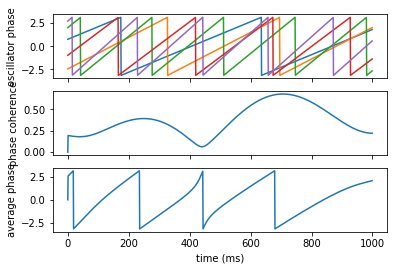

In [1]:
from brian2 import *

oscillators = NeuronGroup(5, '''
omega : Hz (constant)
dtheta/dt = omega : 1''')
# Random frequency, random initial phase
oscillators.omega = '100*Hz + rand()*200*Hz'
oscillators.theta = 'rand()*2*pi'

population = NeuronGroup(1, '''
x : 1
y : 1
coherence = sqrt(x**2 + y**2) : 1
phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1 
''')
population.x = 1e-9  # avoid division by zero

average = Synapses(oscillators, population,
                   '''
                   x_post = cos(theta_pre)/N_incoming : 1 (summed)
                   y_post = sin(theta_pre)/N_incoming : 1 (summed)
                   ''')
average.connect()

mon_osc = StateMonitor(oscillators, 'theta', True)
mon_avg = StateMonitor(population, ['coherence', 'phase'], record=True)

run(100*ms)

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot((mon_osc.theta.T + pi) % (2*pi) - pi)  # Transform to [-π, π]
axs[0].set_ylabel('oscillator phase')
axs[1].plot(mon_avg.coherence[0])
axs[1].set_ylabel('phase coherence')
axs[2].plot(mon_avg.phase[0])
axs[2].set_ylabel('average phase')
axs[2].set_xlabel('time (ms)')
plt.show()

# Adaptation to Kuramoto Oscillators

Below I adapt M. Stimberg's code to the Kuramoto oscillator formalism (no PRC curve yet).

**NOTE:** To calculate the order parameter $re^{j\psi} := \frac{1}{N} \sum_{j=1}^{N} e^{j\theta}$, we calculate the _phase coherence_ `r` and the _average phase_ '$\psi$'. The output rhythm is then given by $r sin(\theta)$.

In [2]:
# Kuramoto oscillators
kuramoto_eqs = '''
    dTheta/dt = ((omega + (kN * PIF)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    Vm = sin(Theta)*mV : volt
    ThetaPreInput : 1
    omega : 1
    kN : 1
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [3]:
# Parameters
duration = 5*second

# Oscillators
seed(42)
N = 50
f0 = 4 # center freq [Hz]
sigma = 0.5 # normal std

In [4]:
# Kuramoto oscillators group
net_kur = Network()
oscillators = NeuronGroup(N, kuramoto_eqs, threshold='True', method='euler', name='Kuramoto_N_%d' %N)
oscillators.Theta = '2*pi*rand()' # uniform U~[0,2π]
oscillators.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
oscillators.kN = 10
osc_synapses = Synapses(oscillators, oscillators, on_pre=syn_kuramoto_eqs)
osc_synapses.connect(condition='i!=j')

# mean phase output
population = NeuronGroup(1, pop_avg_eqs)
r0 = 1/N * sum(exp(1j*oscillators.Theta))
population.x = real(r0)  # avoid division by zero
population.y = imag(r0)
average = Synapses(oscillators, population, syn_avg_eqs)
average.connect()

# monitors
mon_osc = StateMonitor(oscillators, 'Theta', True)
mon_avg = StateMonitor(population, ['coherence', 'phase', 'rhythm'], record=True)

# add all of the above to the network
net_kur.add(oscillators)
net_kur.add(population)
net_kur.add(average)
net_kur.add(mon_osc)
net_kur.add(mon_avg)
net_kur.add(osc_synapses)

# run the simulation
net_kur.run(duration, report='text', report_period=10*second, profile=True)
print("Simulation done")

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 5. s
5. s (100%) simulated in 2s
Simulation done


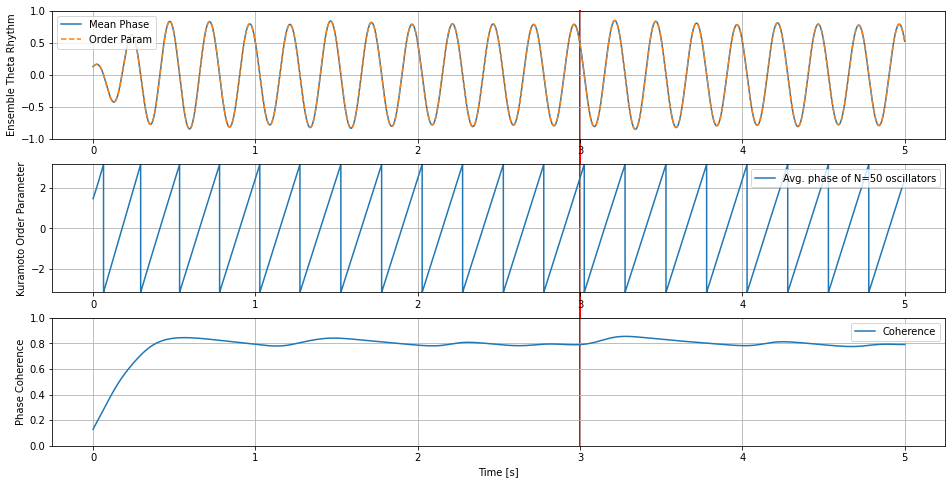

In [5]:
# plot the results
fig, axs = subplots(3,1)
fig.set_figheight(8)
fig.set_figwidth(16)
axs[0].plot(mon_osc.t/second, mean(sin(mon_osc.Theta), axis=0), label='Mean Phase')
#axs[0].plot(mon_avg.t/second, mon_avg.coherence[0]*sin(mon_avg.phase[0]), '--', label='Order Param')
axs[0].plot(mon_avg.t/second, mon_avg.rhythm[0], '--', label='Order Param')
axs[1].plot(mon_avg.t/second, mon_avg.phase[0], '-', label='Avg. phase of N=%d oscillators'%N)
axs[2].plot(mon_avg.t/second, mon_avg.coherence[0], '-', label='Coherence (|r|)')

# labels
axs[0].set_ylabel("Ensemble Theta Rhythm")
axs[1].set_ylabel("Kuramoto Order Parameter")
axs[2].set_ylabel("Phase Coherence")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylim([-1,1])
axs[1].set_ylim([-pi,pi])
axs[2].set_ylim([0,1])
axs[0].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

# make things pretty
axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()
axs[2].legend()
axs[2].grid()

# show
fig.savefig('sample.png', facecolor='white', transparent=False)
show()

Having done all of the above (it works!) let's include stimulation in the Kuramoto equations:

In [6]:
# Kuramoto oscillators
kuramoto_eqs_stim = '''
    dTheta/dt = ((omega + (kN * PIF) - I_stim*X*sin(Theta)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    Vm = sin(Theta)*mV : volt
    ThetaPreInput : 1
    omega : 1
    kN : 1
    I_stim : amp
    X = pulse_train(t) : amp**-1
'''

In [13]:
# parameters

# Oscillators
seed(42)

# Inputs setup
dt_stim = 1*ms
I0 = 10*amp
tv = linspace(0, duration/second, int(duration/(dt_stim))+1)
xstim = 1. * logical_and(tv>3, tv<3.1)
pulse_train = TimedArray(xstim*amp**-1, dt=dt_stim)

In [14]:
# Kuramoto oscillators group
net_kur_stim = Network()
oscillators = NeuronGroup(N, kuramoto_eqs_stim, threshold='True', method='euler', name='Kuramoto_N_%d' %N)
oscillators.Theta = '2*pi*rand()' # uniform U~[0,2π]
oscillators.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
oscillators.kN = 10
oscillators.I_stim = 10*amp
osc_synapses = Synapses(oscillators, oscillators, on_pre=syn_kuramoto_eqs)
osc_synapses.connect(condition='i!=j')

# mean phase output
population = NeuronGroup(1, pop_avg_eqs)
r0 = 1/N * sum(exp(1j*oscillators.Theta))
population.x = real(r0)  # avoid division by zero
population.y = imag(r0)
average = Synapses(oscillators, population, syn_avg_eqs)
average.connect()

# monitors
mon_osc = StateMonitor(oscillators, 'Theta', True)
mon_avg = StateMonitor(population, ['coherence', 'phase', 'rhythm'], record=True)

# add all of the above to the network
net_kur_stim.add(oscillators)
net_kur_stim.add(population)
net_kur_stim.add(average)
net_kur_stim.add(mon_osc)
net_kur_stim.add(mon_avg)
net_kur_stim.add(osc_synapses)

# run the simulation
net_kur_stim.run(duration, report='text', report_period=10*second, profile=True)
print("Simulation done")

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 5. s
5. s (100%) simulated in 2s
Simulation done


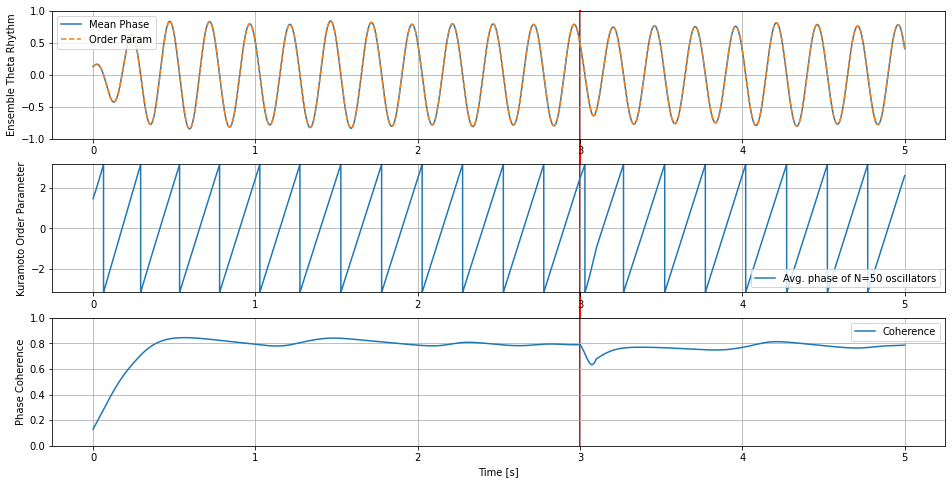

In [15]:
# plot the results
fig, axs = subplots(3,1)
fig.set_figheight(8)
fig.set_figwidth(16)
axs[0].plot(mon_osc.t/second, mean(sin(mon_osc.Theta), axis=0), label='Mean Phase')
#axs[0].plot(mon_avg.t/second, mon_avg.coherence[0]*sin(mon_avg.phase[0]), '--', label='Order Param')
axs[0].plot(mon_avg.t/second, mon_avg.rhythm[0], '--', label='Order Param')
axs[1].plot(mon_avg.t/second, mon_avg.phase[0], '-', label='Avg. phase of N=%d oscillators'%N)
axs[2].plot(mon_avg.t/second, mon_avg.coherence[0], '-', label='Coherence (|r|)')

# labels
axs[0].set_ylabel("Ensemble Theta Rhythm")
axs[1].set_ylabel("Kuramoto Order Parameter")
axs[2].set_ylabel("Phase Coherence")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylim([-1,1])
axs[1].set_ylim([-pi,pi])
axs[2].set_ylim([0,1])
axs[0].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=3, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

# make things pretty
axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()
axs[2].legend()
axs[2].grid()

# show
fig.savefig('sample.png', facecolor='white', transparent=False)
show()

# print(r0)
print(real(r0))
print(imag(r0))